In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import warnings
import glob

warnings.filterwarnings("ignore")
pd.set_option("display.max_columns", 6)
pd.set_option("display.max_rows", 6)
np.random.seed(2)

2025-04-21 18:16:57.552265: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Load the data and process it

In [2]:
dataset_path = "dataset/"

def load_all_scenes():
    scene_ids = [file.split("/")[-1].split(".")[0] for file in glob.glob(f"{dataset_path}*.nodes")]
    all_scenes = []
    for scene_id in scene_ids:
        edges_file = os.path.join(dataset_path, f"{scene_id}.edges")
        nodes_file = os.path.join(dataset_path, f"{scene_id}.nodes")

        edges_df = pd.read_csv(edges_file, header=None, names=["target", "source"], na_values="_")
        nodes_df = pd.read_csv(
            nodes_file,
            header=None,
            names=["node_id", "current_x", "current_y", "previous_x", "previous_y", "future_x", "future_y"],
            na_values="_"
        )

        if nodes_df.isnull().any().any():
            nan_nodes = nodes_df[nodes_df.isnull().any(axis=1)]
            nan_node_ids = nan_nodes["node_id"].tolist()
            edges_df = edges_df[~edges_df["source"].isin(nan_node_ids) & ~edges_df["target"].isin(nan_node_ids)]
            nodes_df = nodes_df.dropna(subset=["future_x", "future_y"])

        if (edges_df["source"] == -1).any() or (edges_df["target"] == -1).any():
            edges_df = edges_df[(edges_df["source"] != -1) & (edges_df["target"] != -1)]
            connected_nodes = pd.unique(edges_df[["target", "source"]].values.ravel())
            nodes_df = nodes_df[nodes_df["node_id"].isin(connected_nodes)]

        nodes_df = nodes_df.replace('_', np.nan)
        edges_df = edges_df.replace('_', np.nan)

        if len(nodes_df) > 0:
            node_id_to_idx = {node_id: idx for idx, node_id in enumerate(nodes_df["node_id"].values)}
            edges_df = edges_df.dropna()
            edges_df['target'] = edges_df['target'].apply(lambda x: node_id_to_idx.get(x, -1))
            edges_df['source'] = edges_df['source'].apply(lambda x: node_id_to_idx.get(x, -1))
            edges_df = edges_df[(edges_df['target'] != -1) & (edges_df['source'] != -1)]

            all_scenes.append({
                "scene_id": scene_id,
                "node_features": tf.convert_to_tensor(
                    nodes_df[["current_x", "current_y", "previous_x", "previous_y"]].values,
                    dtype=tf.float32
                ),
                "labels": tf.convert_to_tensor(nodes_df[["future_x", "future_y"]].values, dtype=tf.float32),
                "edges": tf.convert_to_tensor(edges_df[["target", "source"]].values, dtype=tf.int32),
                "node_indices": np.arange(len(nodes_df)),
            })
            
    return all_scenes


scenes = load_all_scenes()

# Shuffle and split into train, validation, and test sets
np.random.seed(2)
np.random.shuffle(scenes)

""" 70% Training set """
# train_scenes = scenes[:int(0.7 * len(scenes))]
# val_scenes = scenes[int(0.7 * len(scenes)):int(0.9 * len(scenes))]
# test_scenes = scenes[int(0.9 * len(scenes)):]

""" 50% Training set """
train_scenes = scenes[:int(0.5 * len(scenes))]
val_scenes = scenes[int(0.5 * len(scenes)):int(0.9 * len(scenes))]
test_scenes = scenes[int(0.9 * len(scenes)):]

print(f"Total scenes: {len(scenes)}")
print(f"Training scenes: {len(train_scenes)}")
print(f"Validation scenes: {len(val_scenes)}")
print(f"Test scenes: {len(test_scenes)}")

def scene_to_sample(scene):
    return (scene["node_features"], scene["edges"], scene["labels"])

train_samples = [scene_to_sample(scene) for scene in train_scenes]
val_samples = [scene_to_sample(scene) for scene in val_scenes]
test_samples = [scene_to_sample(scene) for scene in test_scenes]

output_signature = (
    tf.TensorSpec(shape=(None, 4), dtype=tf.float32),
    tf.TensorSpec(shape=(None, 2), dtype=tf.int32),
    tf.TensorSpec(shape=(None, 2), dtype=tf.float32),
)

train_dataset = tf.data.Dataset.from_generator(
    lambda: iter(train_samples),
    output_signature=output_signature
)

val_dataset = tf.data.Dataset.from_generator(
    lambda: iter(val_samples),
    output_signature=output_signature
)

test_dataset = tf.data.Dataset.from_generator(
    lambda: iter(test_samples),
    output_signature=output_signature
)

def squeeze_batch(features, edges, targets):
    return tf.squeeze(features, axis=0), tf.squeeze(edges, axis=0), tf.squeeze(targets, axis=0)

train_dataset = train_dataset.shuffle(100).batch(1).map(squeeze_batch)
val_dataset = val_dataset.batch(1).map(squeeze_batch)
test_dataset = test_dataset.batch(1).map(squeeze_batch)


Total scenes: 189
Training scenes: 94
Validation scenes: 76
Test scenes: 19


## GAT model implementation

In [ ]:
class GraphAttention(layers.Layer):
    def __init__(
        self,
        units,
        kernel_initializer="glorot_uniform",
        kernel_regularizer=None,
        **kwargs,
    ):
        super().__init__(**kwargs)
        self.units = units
        self.kernel_initializer = keras.initializers.get(kernel_initializer)
        self.kernel_regularizer = keras.regularizers.get(kernel_regularizer)

    def build(self, input_shape):
        self.kernel = self.add_weight(
            shape=(input_shape[0][-1], self.units),
            trainable=True,
            initializer=self.kernel_initializer,
            regularizer=self.kernel_regularizer,
            name="kernel",
        )
        self.kernel_attention = self.add_weight(
            shape=(self.units * 2, 1),
            trainable=True,
            initializer=self.kernel_initializer,
            regularizer=self.kernel_regularizer,
            name="kernel_attention",
        )
        self.built = True

    def call(self, inputs):
        node_states, edges = inputs

        # Linearly transform node states
        node_states_transformed = tf.matmul(node_states, self.kernel)

        # (1) Compute pair-wise attention scores
        # node_states_expanded = tf.gather(node_states_transformed, edges)
        # node_states_expanded = tf.reshape(
        #     node_states_expanded, (tf.shape(edges)[0], -1)
        # )
        # attention_scores = tf.nn.leaky_relu(
        #     tf.matmul(node_states_expanded, self.kernel_attention)
        # )
        # attention_scores = tf.squeeze(attention_scores, -1)

        # Cosine similarity:
        src = tf.gather(node_states_transformed, edges[:, 0])
        dst = tf.gather(node_states_transformed, edges[:, 1])
        dot_product = tf.reduce_sum(src * dst, axis=1)
        src_norm = tf.norm(src, axis=1)
        dst_norm = tf.norm(dst, axis=1)
        cosine_similarity = dot_product / (src_norm * dst_norm + 1e-8)
        attention_scores = cosine_similarity  # No learnable weights


        # (2) Normalize attention scores
        attention_scores = tf.math.exp(tf.clip_by_value(attention_scores, -2, 2))
        attention_scores_sum = tf.math.unsorted_segment_sum(
            data=attention_scores,
            segment_ids=edges[:, 0],
            num_segments=tf.reduce_max(edges[:, 0]) + 1,
        )
        attention_scores_sum = tf.repeat(
            attention_scores_sum, tf.math.bincount(tf.cast(edges[:, 0], "int32"))
        )
        attention_scores_norm = attention_scores / attention_scores_sum

        # (3) Gather node states of neighbors, apply attention scores and aggregate
        node_states_neighbors = tf.gather(node_states_transformed, edges[:, 1])
        out = tf.math.unsorted_segment_sum(
            data=node_states_neighbors * attention_scores_norm[:, tf.newaxis],
            segment_ids=edges[:, 0],
            num_segments=tf.shape(node_states)[0],
        )
        return out


class MultiHeadGraphAttention(layers.Layer):
    def __init__(self, units, num_heads=8, merge_type="concat", **kwargs):
        super().__init__(**kwargs)
        self.num_heads = num_heads
        self.merge_type = merge_type
        self.attention_layers = [GraphAttention(units) for _ in range(num_heads)]

    def call(self, inputs):
        atom_features, pair_indices = inputs

        # Obtain outputs from each attention head
        outputs = [
            attention_layer([atom_features, pair_indices])
            for attention_layer in self.attention_layers
        ]
        # Concatenate or average the node states from each head
        if self.merge_type == "concat":
            outputs = tf.concat(outputs, axis=-1)
        else:
            outputs = tf.reduce_mean(tf.stack(outputs, axis=-1), axis=-1)
        # Activate and return node states
        return tf.nn.relu(outputs)


class GraphAttentionNetwork(keras.Model):
    def __init__(
        self,
        #node_states,
        #edges,
        hidden_units,
        num_heads,
        num_layers,
        output_dim,
        **kwargs,
    ):
        super().__init__(**kwargs)
        #self.node_states = node_states
        #self.edges = edges
        self.preprocess = keras.Sequential([
            layers.Dense(hidden_units * num_heads, activation="relu"),
            layers.Dense(hidden_units * num_heads, activation="relu"),
            layers.Dense(hidden_units * num_heads, activation=None),
        ])
        #self.preprocess = layers.Dense(hidden_units * num_heads, activation="relu")
        self.attention_layers = [
            MultiHeadGraphAttention(hidden_units, num_heads) for _ in range(num_layers)
        ]
        self.output_layer = layers.Dense(output_dim)

    def call(self, inputs):
        node_states, edges = inputs
        x = self.preprocess(node_states)
        for attention_layer in self.attention_layers:
            x = attention_layer([x, edges]) + x
        outputs = self.output_layer(x)
        return outputs

    def train_step(self, data):
        node_features, edges, labels = data  # Unpack the batch
        with tf.GradientTape() as tape:
            outputs = self([node_features, edges], training=True)
            loss = self.compiled_loss(labels, outputs)
        grads = tape.gradient(loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.compiled_metrics.update_state(labels, outputs)
        logs = {m.name: m.result() for m in self.metrics}
        logs["loss"] = loss
        return logs
    
    def predict_step(self, data):
        node_features, edges, _ = data  # labels may not be present
        outputs = self([node_features, edges], training=False)
        return outputs

    def test_step(self, data):
        node_features, edges, labels = data
        outputs = self([node_features, edges], training=False)
        loss = self.compiled_loss(labels, outputs)
        self.compiled_metrics.update_state(labels, outputs)
        logs = {m.name: m.result() for m in self.metrics}
        logs["loss"] = loss
        return logs


# Task 1 - adjust the model to the new data

In [ ]:
# Define hyper-parameters
HIDDEN_UNITS = 100
NUM_HEADS = 8
NUM_LAYERS = 3
OUTPUT_DIM = 2

NUM_EPOCHS = 100
LEARNING_RATE = 1e-4

# Build model
gat_model = GraphAttentionNetwork(
    HIDDEN_UNITS, NUM_HEADS, NUM_LAYERS, OUTPUT_DIM
)

early_stopping = keras.callbacks.EarlyStopping(
    monitor="val_loss", min_delta=1e-5, patience=10, verbose=1, restore_best_weights=True, start_from_epoch=0
)

reduce_lr = keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss", factor=0.1, patience=5, verbose=1, min_delta=1e-4, min_lr=1e-6
)

loss_fn = keras.losses.MeanSquaredError()
optimizer = keras.optimizers.Adam(learning_rate=LEARNING_RATE)
metrics = [
    keras.metrics.MeanAbsoluteError(),
    keras.metrics.MeanSquaredError(),
    keras.metrics.RootMeanSquaredError(name="rmse"),
    keras.metrics.R2Score(),
]

gat_model.compile(optimizer=optimizer, loss=loss_fn, metrics=metrics)

history = gat_model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=NUM_EPOCHS,
    verbose=2,
    callbacks=[reduce_lr, early_stopping],
)

_, test_accuracy = gat_model.evaluate(x=test_dataset, verbose=1)
print(f"Test Mean Absolute Error: {test_accuracy}")

all_predictions = []
all_ground_truth = []
sample_count = 0

print("Evaluating model on entire test dataset")

for features, edges, targets in test_dataset:
    predictions = gat_model((features, edges), training=False)
    
    # Convert to numpy for easier handling
    pred_np = predictions.numpy()
    targets_np = targets.numpy()
    
    # Store predictions
    all_predictions.append(pred_np)
    all_ground_truth.append(targets_np)
    
    sample_count += len(pred_np)

print(f"Processed {len(all_predictions)} scenes with {sample_count} total nodes")

# Concatenate all predictions and ground truth values
all_pred_concat = np.concatenate(all_predictions)
all_gt_concat = np.concatenate(all_ground_truth)

# Calculate MAE for x and y coordinates separately
mae_x = np.mean(np.abs(all_pred_concat[:, 0] - all_gt_concat[:, 0]))
mae_y = np.mean(np.abs(all_pred_concat[:, 1] - all_gt_concat[:, 1]))

# Calculate overall MAE
mae = np.mean(np.abs(all_pred_concat - all_gt_concat))

# Calculate Euclidean distance for each prediction
euclidean_distances = np.sqrt(np.sum((all_pred_concat - all_gt_concat)**2, axis=1))
mean_euclidean = np.mean(euclidean_distances)
median_euclidean = np.median(euclidean_distances)

print("\n===== Evaluation Metrics =====")
print(f"Mean Absolute Error (overall): {mae:.2f}")
print(f"Mean Absolute Error (x-coordinate): {mae_x:.2f}")
print(f"Mean Absolute Error (y-coordinate): {mae_y:.2f}")
print(f"Mean Euclidean Distance: {mean_euclidean:.2f} units")
print(f"Median Euclidean Distance: {median_euclidean:.2f} units")

num_heads = 8

_, test_accuracy = gat_model.evaluate(x=test_dataset, verbose=1)
print(f"Test Mean Absolute Error: {test_accuracy}")

all_predictions = []
all_ground_truth = []
sample_count = 0

print("Evaluating model on entire test dataset")

for features, edges, targets in test_dataset:
    predictions = gat_model((features, edges), training=False)
    
    # Convert to numpy for easier handling
    pred_np = predictions.numpy()
    targets_np = targets.numpy()
    
    # Store predictions
    all_predictions.append(pred_np)
    all_ground_truth.append(targets_np)
    
    sample_count += len(pred_np)

print(f"Processed {len(all_predictions)} scenes with {sample_count} total nodes")

# Concatenate all predictions and ground truth values
all_pred_concat = np.concatenate(all_predictions)
all_gt_concat = np.concatenate(all_ground_truth)

# Calculate MAE for x and y coordinates separately
mae_x = np.mean(np.abs(all_pred_concat[:, 0] - all_gt_concat[:, 0]))
mae_y = np.mean(np.abs(all_pred_concat[:, 1] - all_gt_concat[:, 1]))

# Calculate overall MAE
mae = np.mean(np.abs(all_pred_concat - all_gt_concat))

# Calculate Euclidean distance for each prediction
euclidean_distances = np.sqrt(np.sum((all_pred_concat - all_gt_concat)**2, axis=1))
mean_euclidean = np.mean(euclidean_distances)
median_euclidean = np.median(euclidean_distances)

histories = []
metrics_list = []

print("\n===== Evaluation Metrics =====")
print(f"Mean Absolute Error (overall): {mae:.2f}")
print(f"Mean Absolute Error (x-coordinate): {mae_x:.2f}")
print(f"Mean Absolute Error (y-coordinate): {mae_y:.2f}")
print(f"Mean Euclidean Distance: {mean_euclidean:.2f} units")
print(f"Median Euclidean Distance: {median_euclidean:.2f} units")
fig, axes = plt.subplots(1, 3, figsize=(18, 4))

# --- Loss plot ---
ax_loss = axes[0]
ax_loss.plot(history.history['loss'], label='Train Loss')
ax_loss.plot(history.history['val_loss'], label='Val Loss')
ax_loss.set_title('Loss (heads=8)')
ax_loss.set_xlabel('Epoch')
ax_loss.set_ylabel('Loss')
ax_loss.legend()
ax_loss.set_yscale("log")

# --- MAE plot ---
ax_mae = axes[1]
ax_mae.plot(history.history['mean_absolute_error'], label='Train MAE')
if 'val_mean_absolute_error' in history.history:
    ax_mae.plot(history.history['val_mean_absolute_error'], label='Val MAE')
ax_mae.set_title('MAE (heads=8)')
ax_mae.set_xlabel('Epoch')
ax_mae.set_ylabel('MAE')
ax_mae.legend()

# --- Metrics table ---
ax_table = axes[2]
ax_table.axis('off')
cell_text = [
    ["MAE (overall)", f"{mae:.2f}"],
    ["MAE (x)", f"{mae_x:.2f}"],
    ["MAE (y)", f"{mae_y:.2f}"],
    ["Mean Euclidean Distance", f"{mean_euclidean:.2f}"],
    ["Median Euclidean Distance", f"{median_euclidean:.2f}"]
]
table = ax_table.table(
    cellText=cell_text,
    colLabels=["Metric", "Value"],
    loc='center',
    cellLoc='left'
)
table.auto_set_font_size(False)
table.set_fontsize(12)
table.scale(1.2, 1.2)
ax_table.set_title("Evaluation Metrics", fontweight="bold")

plt.tight_layout()
plt.savefig("plotsTask1/all_results_grid_task1_heads8.png")
plt.show()

# Task 2 - hyperparamter tuning

Epoch 1/100


2025-04-22 14:48:24.198256: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


94/94 - 34s - 365ms/step - mean_absolute_error: 1120.0133 - mean_squared_error: 1967073.2500 - r2_score: 0.9737 - rmse: 1402.5239 - loss: 766228.1250 - val_loss: 601827.7500 - learning_rate: 1.0000e-04
Epoch 2/100


2025-04-22 14:48:27.647968: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-04-22 14:48:29.604097: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


94/94 - 2s - 24ms/step - mean_absolute_error: 1440.7297 - mean_squared_error: 3658380.7500 - r2_score: 0.9641 - rmse: 1912.6895 - loss: 1374045.8750 - val_loss: 874121.8750 - learning_rate: 1.0000e-04
Epoch 3/100


2025-04-22 14:48:29.894976: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-04-22 14:48:31.833722: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


94/94 - 2s - 24ms/step - mean_absolute_error: 3251.9495 - mean_squared_error: 22225772.0000 - r2_score: 0.5855 - rmse: 4714.4219 - loss: 3721906.0000 - val_loss: 3851875.0000 - learning_rate: 1.0000e-04
Epoch 4/100


2025-04-22 14:48:32.119889: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-04-22 14:48:34.037559: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


94/94 - 2s - 25ms/step - mean_absolute_error: 693.1885 - mean_squared_error: 714112.8750 - r2_score: 0.9912 - rmse: 845.0520 - loss: 718488.1250 - val_loss: 409059.4688 - learning_rate: 1.0000e-04
Epoch 5/100


2025-04-22 14:48:34.425404: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-04-22 14:48:36.404959: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


94/94 - 2s - 24ms/step - mean_absolute_error: 529.0685 - mean_squared_error: 422854.2812 - r2_score: 0.9952 - rmse: 650.2725 - loss: 1374372.0000 - val_loss: 425039.8125 - learning_rate: 1.0000e-04
Epoch 6/100


2025-04-22 14:48:36.691278: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-04-22 14:48:38.676389: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


94/94 - 2s - 24ms/step - mean_absolute_error: 548.2264 - mean_squared_error: 483816.0938 - r2_score: 0.9942 - rmse: 695.5689 - loss: 74905.1719 - val_loss: 317726.6562 - learning_rate: 1.0000e-04
Epoch 7/100


2025-04-22 14:48:38.974717: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-04-22 14:48:41.032538: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


94/94 - 2s - 25ms/step - mean_absolute_error: 495.2242 - mean_squared_error: 371544.5938 - r2_score: 0.9955 - rmse: 609.5446 - loss: 1576441.6250 - val_loss: 342779.6250 - learning_rate: 1.0000e-04
Epoch 8/100


2025-04-22 14:48:41.326351: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-04-22 14:48:43.411951: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


94/94 - 2s - 25ms/step - mean_absolute_error: 1296.2067 - mean_squared_error: 2757890.0000 - r2_score: 0.9751 - rmse: 1660.6896 - loss: 2951595.5000 - val_loss: 356699.7188 - learning_rate: 1.0000e-04
Epoch 9/100


2025-04-22 14:48:43.698002: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-04-22 14:48:45.774324: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


94/94 - 2s - 26ms/step - mean_absolute_error: 520.6785 - mean_squared_error: 447888.3125 - r2_score: 0.9950 - rmse: 669.2446 - loss: 312765.6562 - val_loss: 392539.3125 - learning_rate: 1.0000e-04
Epoch 10/100


2025-04-22 14:48:46.124623: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-04-22 14:48:48.133213: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


94/94 - 2s - 25ms/step - mean_absolute_error: 478.7810 - mean_squared_error: 389833.8750 - r2_score: 0.9956 - rmse: 624.3668 - loss: 368728.0938 - val_loss: 339922.1875 - learning_rate: 1.0000e-04
Epoch 11/100


2025-04-22 14:48:48.442479: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-04-22 14:48:50.380920: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



Epoch 11: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.
94/94 - 2s - 24ms/step - mean_absolute_error: 822.8248 - mean_squared_error: 1016295.3750 - r2_score: 0.9900 - rmse: 1008.1147 - loss: 1015334.0000 - val_loss: 589776.4375 - learning_rate: 1.0000e-04
Epoch 12/100


2025-04-22 14:48:50.680036: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-04-22 14:48:52.746460: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


94/94 - 2s - 26ms/step - mean_absolute_error: 411.4914 - mean_squared_error: 266412.5000 - r2_score: 0.9967 - rmse: 516.1516 - loss: 204802.8281 - val_loss: 351992.8125 - learning_rate: 1.0000e-05
Epoch 13/100


2025-04-22 14:48:53.130260: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-04-22 14:48:55.201829: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


94/94 - 2s - 26ms/step - mean_absolute_error: 391.3649 - mean_squared_error: 247033.3438 - r2_score: 0.9970 - rmse: 497.0245 - loss: 178933.5938 - val_loss: 314503.2188 - learning_rate: 1.0000e-05
Epoch 14/100


2025-04-22 14:48:55.544045: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-04-22 14:48:57.718671: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


94/94 - 2s - 26ms/step - mean_absolute_error: 386.5153 - mean_squared_error: 244097.1250 - r2_score: 0.9970 - rmse: 494.0619 - loss: 128895.9453 - val_loss: 312701.1562 - learning_rate: 1.0000e-05
Epoch 15/100


2025-04-22 14:48:58.005971: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-04-22 14:49:00.278734: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


94/94 - 3s - 27ms/step - mean_absolute_error: 389.5228 - mean_squared_error: 245494.2500 - r2_score: 0.9970 - rmse: 495.4738 - loss: 78829.1797 - val_loss: 318860.1250 - learning_rate: 1.0000e-05
Epoch 16/100


2025-04-22 14:49:00.602904: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-04-22 14:49:02.731591: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


94/94 - 2s - 26ms/step - mean_absolute_error: 381.3951 - mean_squared_error: 237913.0781 - r2_score: 0.9971 - rmse: 487.7633 - loss: 128159.6875 - val_loss: 313217.0000 - learning_rate: 1.0000e-05
Epoch 17/100


2025-04-22 14:49:03.080644: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-04-22 14:49:05.061647: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


94/94 - 2s - 25ms/step - mean_absolute_error: 382.2542 - mean_squared_error: 243597.1250 - r2_score: 0.9971 - rmse: 493.5556 - loss: 440198.5938 - val_loss: 300841.3750 - learning_rate: 1.0000e-05
Epoch 18/100


2025-04-22 14:49:05.455001: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-04-22 14:49:07.430130: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


94/94 - 2s - 24ms/step - mean_absolute_error: 375.3169 - mean_squared_error: 234982.4375 - r2_score: 0.9971 - rmse: 484.7499 - loss: 233868.3438 - val_loss: 297043.8438 - learning_rate: 1.0000e-05
Epoch 19/100


2025-04-22 14:49:07.717755: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-04-22 14:49:09.743862: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


94/94 - 2s - 25ms/step - mean_absolute_error: 393.9209 - mean_squared_error: 259988.1094 - r2_score: 0.9970 - rmse: 509.8903 - loss: 57635.1055 - val_loss: 284560.5000 - learning_rate: 1.0000e-05
Epoch 20/100


2025-04-22 14:49:10.075606: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-04-22 14:49:12.191337: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


94/94 - 3s - 27ms/step - mean_absolute_error: 403.9592 - mean_squared_error: 245742.7812 - r2_score: 0.9969 - rmse: 495.7245 - loss: 102327.0547 - val_loss: 325993.2812 - learning_rate: 1.0000e-05
Epoch 21/100


2025-04-22 14:49:12.668026: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-04-22 14:49:14.611945: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


94/94 - 2s - 24ms/step - mean_absolute_error: 366.4969 - mean_squared_error: 221012.5938 - r2_score: 0.9972 - rmse: 470.1198 - loss: 69606.5625 - val_loss: 313629.8750 - learning_rate: 1.0000e-05
Epoch 22/100


2025-04-22 14:49:14.900023: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-04-22 14:49:16.848170: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


94/94 - 2s - 24ms/step - mean_absolute_error: 364.3981 - mean_squared_error: 214014.7188 - r2_score: 0.9974 - rmse: 462.6172 - loss: 66315.5234 - val_loss: 304383.7500 - learning_rate: 1.0000e-05
Epoch 23/100


2025-04-22 14:49:17.142479: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-04-22 14:49:19.142728: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


94/94 - 2s - 25ms/step - mean_absolute_error: 378.0159 - mean_squared_error: 225802.7188 - r2_score: 0.9972 - rmse: 475.1870 - loss: 272524.0625 - val_loss: 324785.1250 - learning_rate: 1.0000e-05
Epoch 24/100


2025-04-22 14:49:19.545276: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-04-22 14:49:21.611500: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



Epoch 24: ReduceLROnPlateau reducing learning rate to 1e-06.
94/94 - 2s - 25ms/step - mean_absolute_error: 364.7018 - mean_squared_error: 214752.0312 - r2_score: 0.9973 - rmse: 463.4135 - loss: 69490.8906 - val_loss: 289111.4688 - learning_rate: 1.0000e-05
Epoch 25/100


2025-04-22 14:49:21.904532: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-04-22 14:49:23.907897: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


94/94 - 2s - 24ms/step - mean_absolute_error: 357.6745 - mean_squared_error: 207261.6250 - r2_score: 0.9974 - rmse: 455.2599 - loss: 223295.2031 - val_loss: 301205.9375 - learning_rate: 1.0000e-06
Epoch 26/100


2025-04-22 14:49:24.208111: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-04-22 14:49:26.178117: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


94/94 - 2s - 25ms/step - mean_absolute_error: 353.9158 - mean_squared_error: 206636.8906 - r2_score: 0.9974 - rmse: 454.5733 - loss: 326173.9688 - val_loss: 298950.6875 - learning_rate: 1.0000e-06
Epoch 27/100


2025-04-22 14:49:26.567302: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-04-22 14:49:28.606958: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


94/94 - 2s - 25ms/step - mean_absolute_error: 352.0468 - mean_squared_error: 205898.0156 - r2_score: 0.9975 - rmse: 453.7599 - loss: 277914.3438 - val_loss: 289712.6875 - learning_rate: 1.0000e-06
Epoch 28/100


2025-04-22 14:49:28.900978: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-04-22 14:49:31.003673: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


94/94 - 2s - 27ms/step - mean_absolute_error: 352.8185 - mean_squared_error: 206206.5312 - r2_score: 0.9975 - rmse: 454.0997 - loss: 100289.4141 - val_loss: 291551.5938 - learning_rate: 1.0000e-06
Epoch 29/100


2025-04-22 14:49:31.405437: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-04-22 14:49:33.678239: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


94/94 - 3s - 28ms/step - mean_absolute_error: 353.7365 - mean_squared_error: 206696.1719 - r2_score: 0.9974 - rmse: 454.6385 - loss: 47874.8438 - val_loss: 299257.2812 - learning_rate: 1.0000e-06
Epoch 29: early stopping
Restoring model weights from the end of the best epoch: 19.
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - mean_absolute_error: 430.3572 - mean_squared_error: 294434.1250 - r2_score: 0.9889 - rmse: 541.8932 - loss: 299886.7812


2025-04-22 14:49:34.040642: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-04-22 14:49:34.176951: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


Test Mean Absolute Error: {'mean_absolute_error': <tf.Tensor: shape=(), dtype=float32, numpy=418.9768>, 'mean_squared_error': <tf.Tensor: shape=(), dtype=float32, numpy=281610.53>, 'rmse': <tf.Tensor: shape=(), dtype=float32, numpy=530.66986>, 'r2_score': <tf.Tensor: shape=(), dtype=float32, numpy=0.99681574>}
Evaluating model on entire test dataset


2025-04-22 14:49:40.647356: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Processed 19 scenes with 170 total nodes

===== Evaluation Metrics =====
Mean Absolute Error (overall): 418.98
Mean Absolute Error (x-coordinate): 402.07
Mean Absolute Error (y-coordinate): 435.88
Mean Euclidean Distance: 651.51 units
Median Euclidean Distance: 585.75 units
Epoch 1/100


2025-04-22 14:50:42.100239: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


94/94 - 70s - 741ms/step - mean_absolute_error: 762.5697 - mean_squared_error: 984866.6250 - r2_score: 0.9866 - rmse: 992.4045 - loss: 820955.8750 - val_loss: 440809.8750 - learning_rate: 1.0000e-04
Epoch 2/100


2025-04-22 14:50:50.566589: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-04-22 14:50:59.170642: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


94/94 - 9s - 98ms/step - mean_absolute_error: 633.0090 - mean_squared_error: 742671.6250 - r2_score: 0.9916 - rmse: 861.7840 - loss: 760051.1875 - val_loss: 413400.1562 - learning_rate: 1.0000e-04
Epoch 3/100


2025-04-22 14:50:59.850585: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-04-22 14:51:07.552862: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


94/94 - 8s - 90ms/step - mean_absolute_error: 682.3583 - mean_squared_error: 1347111.7500 - r2_score: 0.9852 - rmse: 1160.6515 - loss: 468498.7500 - val_loss: 448784.3750 - learning_rate: 1.0000e-04
Epoch 4/100


2025-04-22 14:51:08.395329: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-04-22 14:51:15.936623: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


94/94 - 8s - 87ms/step - mean_absolute_error: 755.2201 - mean_squared_error: 964572.8125 - r2_score: 0.9895 - rmse: 982.1266 - loss: 837519.8750 - val_loss: 476090.3750 - learning_rate: 1.0000e-04
Epoch 5/100


2025-04-22 14:51:16.577911: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-04-22 14:51:23.757216: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


94/94 - 8s - 86ms/step - mean_absolute_error: 1879.2610 - mean_squared_error: 6512363.0000 - r2_score: 0.9078 - rmse: 2551.9331 - loss: 7326134.0000 - val_loss: 1036451.2500 - learning_rate: 1.0000e-04
Epoch 6/100


2025-04-22 14:51:24.616980: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-04-22 14:51:33.497058: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


94/94 - 10s - 103ms/step - mean_absolute_error: 730.2830 - mean_squared_error: 853673.9375 - r2_score: 0.9893 - rmse: 923.9448 - loss: 424091.9688 - val_loss: 428014.1250 - learning_rate: 1.0000e-04
Epoch 7/100


2025-04-22 14:51:34.303066: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-04-22 14:51:42.304937: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



Epoch 7: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.
94/94 - 9s - 93ms/step - mean_absolute_error: 1596.9629 - mean_squared_error: 3518380.7500 - r2_score: 0.9520 - rmse: 1875.7347 - loss: 459399.6250 - val_loss: 1038886.7500 - learning_rate: 1.0000e-04
Epoch 8/100


2025-04-22 14:51:43.029124: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-04-22 14:51:50.254942: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


94/94 - 8s - 84ms/step - mean_absolute_error: 396.0604 - mean_squared_error: 263522.5938 - r2_score: 0.9968 - rmse: 513.3445 - loss: 255870.2031 - val_loss: 313742.1875 - learning_rate: 1.0000e-05
Epoch 9/100


2025-04-22 14:51:50.882037: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-04-22 14:51:58.126873: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


94/94 - 8s - 84ms/step - mean_absolute_error: 408.4312 - mean_squared_error: 259963.7656 - r2_score: 0.9969 - rmse: 509.8664 - loss: 263986.0938 - val_loss: 330547.1250 - learning_rate: 1.0000e-05
Epoch 10/100


2025-04-22 14:51:58.810632: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-04-22 14:52:05.776768: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


94/94 - 8s - 81ms/step - mean_absolute_error: 414.5541 - mean_squared_error: 258812.3438 - r2_score: 0.9967 - rmse: 508.7360 - loss: 285490.4688 - val_loss: 342534.0625 - learning_rate: 1.0000e-05
Epoch 11/100


2025-04-22 14:52:06.403761: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-04-22 14:52:13.804575: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


94/94 - 8s - 87ms/step - mean_absolute_error: 379.0684 - mean_squared_error: 228834.1094 - r2_score: 0.9971 - rmse: 478.3661 - loss: 113631.5391 - val_loss: 306353.4062 - learning_rate: 1.0000e-05
Epoch 12/100


2025-04-22 14:52:14.504665: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-04-22 14:52:22.332770: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


94/94 - 8s - 90ms/step - mean_absolute_error: 375.4970 - mean_squared_error: 225497.6094 - r2_score: 0.9972 - rmse: 474.8659 - loss: 70563.4609 - val_loss: 313229.1562 - learning_rate: 1.0000e-05
Epoch 13/100


2025-04-22 14:52:23.034959: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-04-22 14:52:30.808999: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


94/94 - 9s - 91ms/step - mean_absolute_error: 369.2015 - mean_squared_error: 228798.0938 - r2_score: 0.9971 - rmse: 478.3284 - loss: 79537.0312 - val_loss: 284674.3750 - learning_rate: 1.0000e-05
Epoch 14/100


2025-04-22 14:52:31.502384: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-04-22 14:52:39.153923: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


94/94 - 8s - 89ms/step - mean_absolute_error: 379.3560 - mean_squared_error: 230314.1094 - r2_score: 0.9970 - rmse: 479.9105 - loss: 235477.2500 - val_loss: 276445.7812 - learning_rate: 1.0000e-05
Epoch 15/100


2025-04-22 14:52:39.859843: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-04-22 14:52:47.047395: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


94/94 - 8s - 83ms/step - mean_absolute_error: 351.3246 - mean_squared_error: 210248.9844 - r2_score: 0.9974 - rmse: 458.5291 - loss: 152673.3594 - val_loss: 287313.8750 - learning_rate: 1.0000e-05
Epoch 16/100


2025-04-22 14:52:47.744904: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-04-22 14:52:55.770590: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


94/94 - 9s - 93ms/step - mean_absolute_error: 350.2778 - mean_squared_error: 207454.0312 - r2_score: 0.9974 - rmse: 455.4712 - loss: 365101.2812 - val_loss: 291196.5625 - learning_rate: 1.0000e-05
Epoch 17/100


2025-04-22 14:52:56.484000: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-04-22 14:53:04.080694: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


94/94 - 8s - 88ms/step - mean_absolute_error: 360.1153 - mean_squared_error: 203169.0469 - r2_score: 0.9974 - rmse: 450.7428 - loss: 222219.4062 - val_loss: 306305.3750 - learning_rate: 1.0000e-05
Epoch 18/100


2025-04-22 14:53:04.732107: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-04-22 14:53:12.676579: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


94/94 - 9s - 92ms/step - mean_absolute_error: 346.9939 - mean_squared_error: 201661.4844 - r2_score: 0.9974 - rmse: 449.0674 - loss: 230532.4375 - val_loss: 269924.6562 - learning_rate: 1.0000e-05
Epoch 19/100


2025-04-22 14:53:13.338871: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-04-22 14:53:20.486692: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


94/94 - 8s - 82ms/step - mean_absolute_error: 351.0581 - mean_squared_error: 194028.5469 - r2_score: 0.9975 - rmse: 440.4867 - loss: 240664.6406 - val_loss: 292099.8750 - learning_rate: 1.0000e-05
Epoch 20/100


2025-04-22 14:53:21.126946: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-04-22 14:53:28.135891: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


94/94 - 8s - 81ms/step - mean_absolute_error: 361.6323 - mean_squared_error: 205463.4844 - r2_score: 0.9974 - rmse: 453.2808 - loss: 248415.6094 - val_loss: 294533.6562 - learning_rate: 1.0000e-05
Epoch 21/100


2025-04-22 14:53:28.777260: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-04-22 14:53:36.448643: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


94/94 - 8s - 89ms/step - mean_absolute_error: 326.1808 - mean_squared_error: 175941.6719 - r2_score: 0.9978 - rmse: 419.4540 - loss: 179848.0938 - val_loss: 274226.0000 - learning_rate: 1.0000e-05
Epoch 22/100


2025-04-22 14:53:37.131287: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-04-22 14:53:44.480105: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


94/94 - 8s - 85ms/step - mean_absolute_error: 383.8723 - mean_squared_error: 222311.2031 - r2_score: 0.9974 - rmse: 471.4989 - loss: 275349.9688 - val_loss: 309413.4375 - learning_rate: 1.0000e-05
Epoch 23/100


2025-04-22 14:53:45.156703: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-04-22 14:53:52.383889: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



Epoch 23: ReduceLROnPlateau reducing learning rate to 1e-06.
94/94 - 8s - 83ms/step - mean_absolute_error: 324.8570 - mean_squared_error: 179176.7188 - r2_score: 0.9978 - rmse: 423.2927 - loss: 312859.1250 - val_loss: 278081.9062 - learning_rate: 1.0000e-05
Epoch 24/100


2025-04-22 14:53:53.012359: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-04-22 14:54:00.629268: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


94/94 - 8s - 89ms/step - mean_absolute_error: 314.4965 - mean_squared_error: 163654.0938 - r2_score: 0.9979 - rmse: 404.5418 - loss: 72070.8516 - val_loss: 267967.4062 - learning_rate: 1.0000e-06
Epoch 25/100


2025-04-22 14:54:01.314172: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-04-22 14:54:08.866409: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


94/94 - 8s - 87ms/step - mean_absolute_error: 312.9763 - mean_squared_error: 163134.4375 - r2_score: 0.9979 - rmse: 403.8990 - loss: 60876.4766 - val_loss: 269255.5000 - learning_rate: 1.0000e-06
Epoch 26/100


2025-04-22 14:54:09.555196: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-04-22 14:54:17.022353: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


94/94 - 8s - 87ms/step - mean_absolute_error: 312.9803 - mean_squared_error: 163664.3125 - r2_score: 0.9979 - rmse: 404.5545 - loss: 64007.8398 - val_loss: 265247.2188 - learning_rate: 1.0000e-06
Epoch 27/100


2025-04-22 14:54:17.654682: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-04-22 14:54:25.301731: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


94/94 - 8s - 88ms/step - mean_absolute_error: 317.0163 - mean_squared_error: 164652.9375 - r2_score: 0.9979 - rmse: 405.7745 - loss: 96433.7188 - val_loss: 263303.6875 - learning_rate: 1.0000e-06
Epoch 28/100


2025-04-22 14:54:25.928391: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-04-22 14:54:33.566026: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


94/94 - 8s - 88ms/step - mean_absolute_error: 310.3659 - mean_squared_error: 161960.8750 - r2_score: 0.9980 - rmse: 402.4436 - loss: 144055.2812 - val_loss: 263522.1562 - learning_rate: 1.0000e-06
Epoch 29/100


2025-04-22 14:54:34.229516: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-04-22 14:54:42.415745: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


94/94 - 9s - 95ms/step - mean_absolute_error: 310.8591 - mean_squared_error: 162317.2344 - r2_score: 0.9980 - rmse: 402.8861 - loss: 139340.1562 - val_loss: 261364.0312 - learning_rate: 1.0000e-06
Epoch 30/100


2025-04-22 14:54:43.144106: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-04-22 14:54:50.940890: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


94/94 - 8s - 90ms/step - mean_absolute_error: 311.9791 - mean_squared_error: 164685.4531 - r2_score: 0.9979 - rmse: 405.8145 - loss: 273778.8125 - val_loss: 256888.3906 - learning_rate: 1.0000e-06
Epoch 31/100


2025-04-22 14:54:51.626209: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-04-22 14:54:59.055053: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


94/94 - 8s - 85ms/step - mean_absolute_error: 310.1526 - mean_squared_error: 162599.1875 - r2_score: 0.9980 - rmse: 403.2359 - loss: 177437.4375 - val_loss: 258861.8125 - learning_rate: 1.0000e-06
Epoch 32/100


2025-04-22 14:54:59.698524: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-04-22 14:55:06.966803: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


94/94 - 8s - 84ms/step - mean_absolute_error: 309.5723 - mean_squared_error: 161527.2344 - r2_score: 0.9980 - rmse: 401.9045 - loss: 55045.2930 - val_loss: 262352.8125 - learning_rate: 1.0000e-06
Epoch 33/100


2025-04-22 14:55:07.619056: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-04-22 14:55:14.876480: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


94/94 - 8s - 84ms/step - mean_absolute_error: 315.6459 - mean_squared_error: 163812.3281 - r2_score: 0.9979 - rmse: 404.7374 - loss: 193969.6719 - val_loss: 275972.9688 - learning_rate: 1.0000e-06
Epoch 34/100


2025-04-22 14:55:15.502812: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-04-22 14:55:22.679984: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


94/94 - 8s - 84ms/step - mean_absolute_error: 310.8333 - mean_squared_error: 163889.3594 - r2_score: 0.9979 - rmse: 404.8325 - loss: 117321.5234 - val_loss: 252674.9219 - learning_rate: 1.0000e-06
Epoch 35/100


2025-04-22 14:55:23.343670: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-04-22 14:55:31.036619: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


94/94 - 8s - 88ms/step - mean_absolute_error: 307.2421 - mean_squared_error: 158574.2812 - r2_score: 0.9980 - rmse: 398.2139 - loss: 69350.4688 - val_loss: 263660.6250 - learning_rate: 1.0000e-06
Epoch 36/100


2025-04-22 14:55:31.703416: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-04-22 14:55:38.996262: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


94/94 - 8s - 84ms/step - mean_absolute_error: 309.3124 - mean_squared_error: 159043.8125 - r2_score: 0.9980 - rmse: 398.8030 - loss: 66874.1406 - val_loss: 263125.2812 - learning_rate: 1.0000e-06
Epoch 37/100


2025-04-22 14:55:39.646240: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-04-22 14:55:46.814248: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


94/94 - 8s - 83ms/step - mean_absolute_error: 323.0613 - mean_squared_error: 167323.0625 - r2_score: 0.9980 - rmse: 409.0514 - loss: 264744.0000 - val_loss: 273495.3750 - learning_rate: 1.0000e-06
Epoch 38/100


2025-04-22 14:55:47.477362: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-04-22 14:55:54.555714: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


94/94 - 8s - 82ms/step - mean_absolute_error: 307.4579 - mean_squared_error: 158734.7656 - r2_score: 0.9980 - rmse: 398.4153 - loss: 53966.0742 - val_loss: 257743.6719 - learning_rate: 1.0000e-06
Epoch 39/100


2025-04-22 14:55:55.180113: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-04-22 14:56:02.474624: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


94/94 - 8s - 84ms/step - mean_absolute_error: 305.5454 - mean_squared_error: 157025.0938 - r2_score: 0.9980 - rmse: 396.2639 - loss: 36881.3672 - val_loss: 261919.2188 - learning_rate: 1.0000e-06
Epoch 40/100


2025-04-22 14:56:03.103099: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-04-22 14:56:10.897620: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


94/94 - 8s - 90ms/step - mean_absolute_error: 309.8315 - mean_squared_error: 157949.0938 - r2_score: 0.9980 - rmse: 397.4281 - loss: 324512.9062 - val_loss: 265302.9062 - learning_rate: 1.0000e-06
Epoch 41/100


2025-04-22 14:56:11.578577: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-04-22 14:56:19.033398: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


94/94 - 8s - 86ms/step - mean_absolute_error: 303.2388 - mean_squared_error: 155193.6406 - r2_score: 0.9980 - rmse: 393.9462 - loss: 166558.0938 - val_loss: 258956.8125 - learning_rate: 1.0000e-06
Epoch 42/100


2025-04-22 14:56:19.675661: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-04-22 14:56:26.932956: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


94/94 - 8s - 84ms/step - mean_absolute_error: 306.7840 - mean_squared_error: 157305.8125 - r2_score: 0.9980 - rmse: 396.6180 - loss: 107212.3516 - val_loss: 260469.0000 - learning_rate: 1.0000e-06
Epoch 43/100


2025-04-22 14:56:27.578050: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-04-22 14:56:34.903123: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


94/94 - 8s - 85ms/step - mean_absolute_error: 314.9345 - mean_squared_error: 160984.0312 - r2_score: 0.9980 - rmse: 401.2281 - loss: 93654.5156 - val_loss: 269747.0000 - learning_rate: 1.0000e-06
Epoch 44/100


2025-04-22 14:56:35.555518: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-04-22 14:56:43.024382: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


94/94 - 8s - 86ms/step - mean_absolute_error: 313.4960 - mean_squared_error: 159973.6719 - r2_score: 0.9980 - rmse: 399.9671 - loss: 120525.8516 - val_loss: 273281.3125 - learning_rate: 1.0000e-06
Epoch 44: early stopping
Restoring model weights from the end of the best epoch: 34.
      7/Unknown 0s 9ms/step - mean_absolute_error: 358.7712 - mean_squared_error: 200781.5000 - r2_score: 0.9822 - rmse: 446.4794 - loss: 192248.7031 

2025-04-22 14:56:43.675959: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - mean_absolute_error: 351.7067 - mean_squared_error: 197857.2031 - r2_score: 0.9923 - rmse: 444.1595 - loss: 200924.2812
Test Mean Absolute Error: {'mean_absolute_error': <tf.Tensor: shape=(), dtype=float32, numpy=346.87067>, 'mean_squared_error': <tf.Tensor: shape=(), dtype=float32, numpy=192300.78>, 'rmse': <tf.Tensor: shape=(), dtype=float32, numpy=438.52112>, 'r2_score': <tf.Tensor: shape=(), dtype=float32, numpy=0.9976968>}
Evaluating model on entire test dataset


2025-04-22 14:56:43.943382: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-04-22 14:56:52.886249: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Processed 19 scenes with 170 total nodes

===== Evaluation Metrics =====
Mean Absolute Error (overall): 346.87
Mean Absolute Error (x-coordinate): 317.44
Mean Absolute Error (y-coordinate): 376.30
Mean Euclidean Distance: 538.30 units
Median Euclidean Distance: 503.21 units


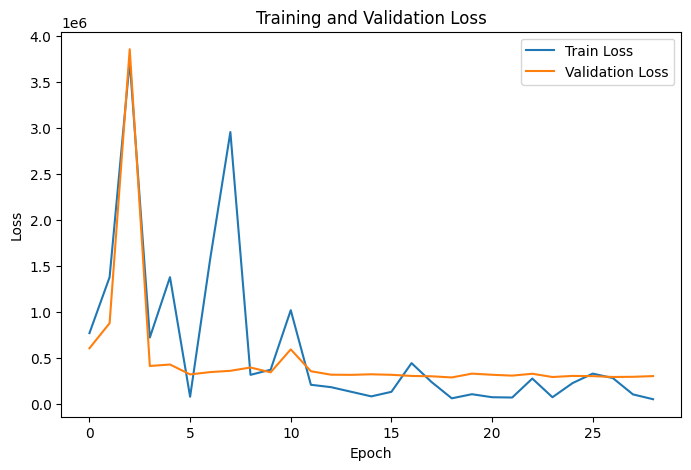

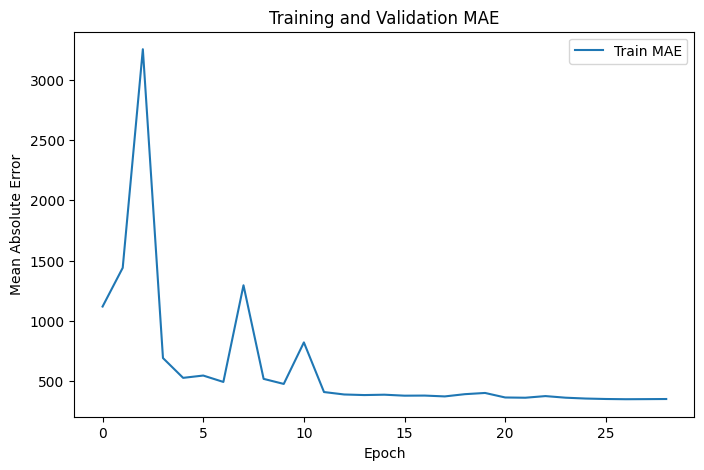

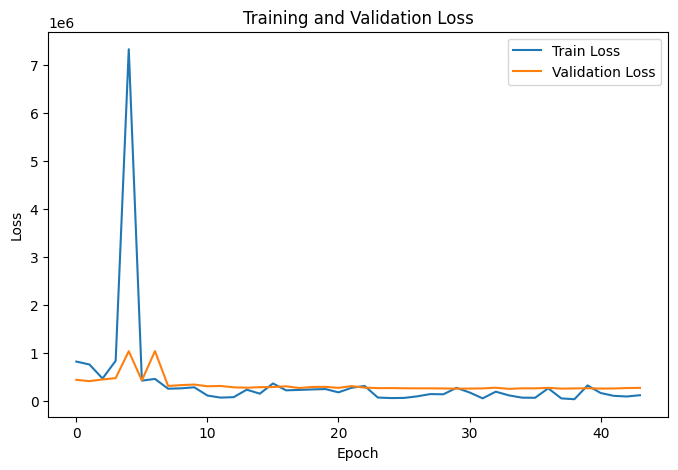

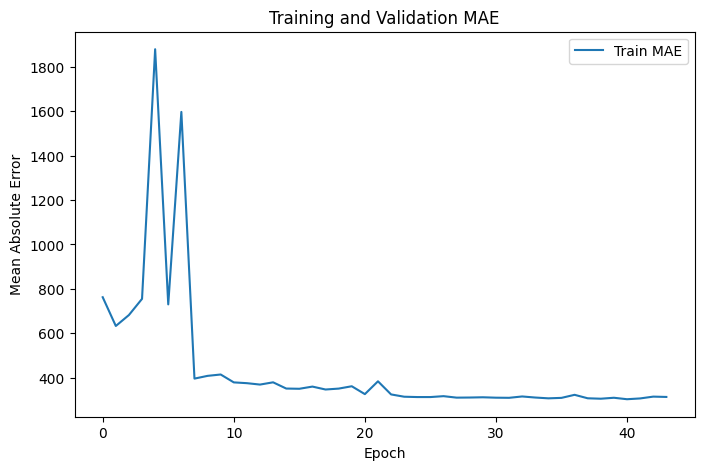

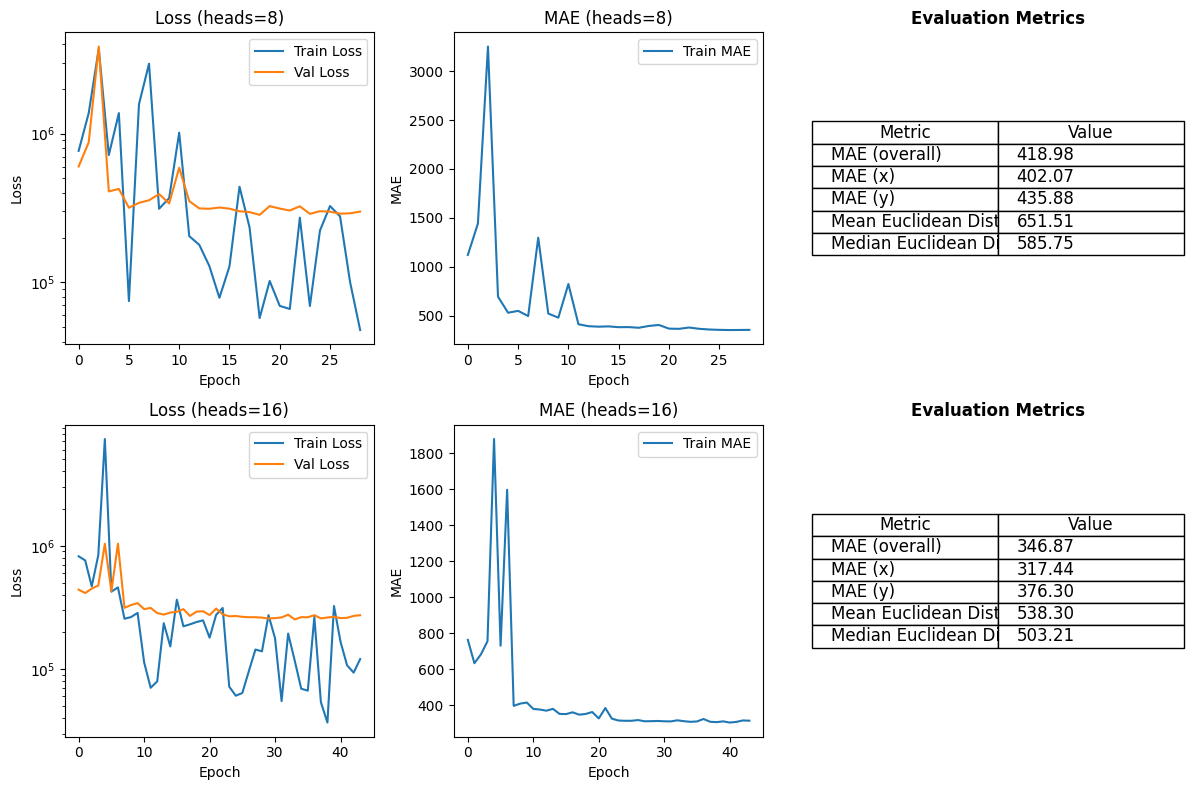

In [34]:
""" 
Perform hyperparameter tuning of the number of attention heads and try a deeper embedding of the node
features. For the attention heads, just evaluate 2 additional settings. For the embedding of the node features,
instead of the linear transformation of the node states as suggested in the tutorial, try to add one fully connected
layer with ReLU activation and one additional fully connected layer.
"""

NUM_HEADS_LIST = [8, 16]
histories = []
metrics_list = []

for num_heads in NUM_HEADS_LIST:
    # Define hyper-parameters
    HIDDEN_UNITS = 100
    NUM_HEADS = num_heads
    NUM_LAYERS = 3
    OUTPUT_DIM = 2

    NUM_EPOCHS = 100
    LEARNING_RATE = 1e-4

    # Build model
    gat_model = GraphAttentionNetwork(
        HIDDEN_UNITS, NUM_HEADS, NUM_LAYERS, OUTPUT_DIM
    )

    early_stopping = keras.callbacks.EarlyStopping(
        monitor="val_loss", min_delta=1e-5, patience=10, verbose=1, restore_best_weights=True, start_from_epoch=0
    )

    reduce_lr = keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss", factor=0.1, patience=5, verbose=1, min_delta=1e-4, min_lr=1e-6
    )

    loss_fn = keras.losses.MeanSquaredError()
    optimizer = keras.optimizers.Adam(learning_rate=LEARNING_RATE)
    metrics = [
        keras.metrics.MeanAbsoluteError(),
        keras.metrics.MeanSquaredError(),
        keras.metrics.RootMeanSquaredError(name="rmse"),
        keras.metrics.R2Score(),
    ]

    gat_model.compile(optimizer=optimizer, loss=loss_fn, metrics=metrics)

    history = gat_model.fit(
        train_dataset,
        validation_data=val_dataset,
        epochs=NUM_EPOCHS,
        verbose=2,
        callbacks=[reduce_lr, early_stopping],
    )

    _, test_accuracy = gat_model.evaluate(x=test_dataset, verbose=1)
    print(f"Test Mean Absolute Error: {test_accuracy}")

    all_predictions = []
    all_ground_truth = []
    sample_count = 0

    print("Evaluating model on entire test dataset")

    for features, edges, targets in test_dataset:
        predictions = gat_model((features, edges), training=False)
        
        # Convert to numpy for easier handling
        pred_np = predictions.numpy()
        targets_np = targets.numpy()
        
        # Store predictions
        all_predictions.append(pred_np)
        all_ground_truth.append(targets_np)
        
        sample_count += len(pred_np)

    print(f"Processed {len(all_predictions)} scenes with {sample_count} total nodes")

    # Concatenate all predictions and ground truth values
    all_pred_concat = np.concatenate(all_predictions)
    all_gt_concat = np.concatenate(all_ground_truth)

    # Calculate MAE for x and y coordinates separately
    mae_x = np.mean(np.abs(all_pred_concat[:, 0] - all_gt_concat[:, 0]))
    mae_y = np.mean(np.abs(all_pred_concat[:, 1] - all_gt_concat[:, 1]))

    # Calculate overall MAE
    mae = np.mean(np.abs(all_pred_concat - all_gt_concat))

    # Calculate Euclidean distance for each prediction
    euclidean_distances = np.sqrt(np.sum((all_pred_concat - all_gt_concat)**2, axis=1))
    mean_euclidean = np.mean(euclidean_distances)
    median_euclidean = np.median(euclidean_distances)

    print("\n===== Evaluation Metrics =====")
    print(f"Mean Absolute Error (overall): {mae:.2f}")
    print(f"Mean Absolute Error (x-coordinate): {mae_x:.2f}")
    print(f"Mean Absolute Error (y-coordinate): {mae_y:.2f}")
    print(f"Mean Euclidean Distance: {mean_euclidean:.2f} units")
    print(f"Median Euclidean Distance: {median_euclidean:.2f} units")

    histories.append(history)
    metrics_list.append({
        "num_heads": num_heads,
        "mae": mae,
        "mae_x": mae_x,
        "mae_y": mae_y,
        "mean_euclidean": mean_euclidean,
        "median_euclidean": median_euclidean
    })


    plt.figure(figsize=(8, 5))
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.savefig(f"plotsTask2/loss_plot_heads{num_heads}_task2.png")
    #plt.show()
    

    plt.figure(figsize=(8, 5))
    plt.plot(history.history['mean_absolute_error'], label='Train MAE')
    if 'val_mean_absolute_error' in history.history:
        plt.plot(history.history['val_mean_absolute_error'], label='Validation MAE')
    plt.xlabel('Epoch')
    plt.ylabel('Mean Absolute Error')
    plt.title('Training and Validation MAE')
    plt.legend()
    plt.savefig(f"plotsTask2/MAE_plot_heads{num_heads}_task2.png")
    #plt.show()


fig, axes = plt.subplots(2, 3, figsize=(12, 8))

for idx, (history, metrics) in enumerate(zip(histories, metrics_list)):
    row = idx

    # --- Loss plot ---
    ax_loss = axes[row, 0]
    ax_loss.plot(history.history['loss'], label='Train Loss')
    ax_loss.plot(history.history['val_loss'], label='Val Loss')
    ax_loss.set_title(f'Loss (heads={metrics["num_heads"]})')
    ax_loss.set_xlabel('Epoch')
    ax_loss.set_ylabel('Loss')
    ax_loss.legend()
    ax_loss.set_yscale("log")

    # --- MAE plot ---
    ax_mae = axes[row, 1]
    ax_mae.plot(history.history['mean_absolute_error'], label='Train MAE')
    if 'val_mean_absolute_error' in history.history:
        ax_mae.plot(history.history['val_mean_absolute_error'], label='Val MAE')
    ax_mae.set_title(f'MAE (heads={metrics["num_heads"]})')
    ax_mae.set_xlabel('Epoch')
    ax_mae.set_ylabel('MAE')
    ax_mae.legend()

    # --- Metrics table ---
    ax_table = axes[row, 2]
    ax_table.axis('off')
    cell_text = [
        ["MAE (overall)", f"{metrics['mae']:.2f}"],
        ["MAE (x)", f"{metrics['mae_x']:.2f}"],
        ["MAE (y)", f"{metrics['mae_y']:.2f}"],
        ["Mean Euclidean Distance", f"{metrics['mean_euclidean']:.2f}"],
        ["Median Euclidean Distance", f"{metrics['median_euclidean']:.2f}"]
    ]
    table = ax_table.table(
        cellText=cell_text,
        colLabels=["Metric", "Value"],
        loc='center',
        cellLoc='left'
    )
    table.auto_set_font_size(False)
    table.set_fontsize(12)
    table.scale(1.2, 1.2)
    ax_table.set_title("Evaluation Metrics", fontweight="bold")

plt.tight_layout()
plt.savefig("plotsTask2/all_results_grid_task2.png")
plt.show()

# Task 3 replace attention mechanism with cosine similarity

Epoch 1/100


2025-04-22 14:23:15.581375: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


94/94 - 36s - 382ms/step - mean_absolute_error: 1222.6287 - mean_squared_error: 2764666.2500 - r2_score: 0.9738 - rmse: 1662.7285 - loss: 1475721.7500 - val_loss: 557669.1250 - learning_rate: 1.0000e-04
Epoch 2/100


2025-04-22 14:23:19.718787: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-04-22 14:23:21.792326: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


94/94 - 2s - 26ms/step - mean_absolute_error: 752.8322 - mean_squared_error: 881712.8750 - r2_score: 0.9897 - rmse: 938.9957 - loss: 678163.0625 - val_loss: 455643.4375 - learning_rate: 1.0000e-04
Epoch 3/100


2025-04-22 14:23:22.170690: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-04-22 14:23:24.105335: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


94/94 - 2s - 24ms/step - mean_absolute_error: 886.4357 - mean_squared_error: 1375695.2500 - r2_score: 0.9790 - rmse: 1172.9004 - loss: 1393624.7500 - val_loss: 552525.1250 - learning_rate: 1.0000e-04
Epoch 4/100


2025-04-22 14:23:24.408661: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-04-22 14:23:26.283752: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


94/94 - 2s - 23ms/step - mean_absolute_error: 781.0289 - mean_squared_error: 1014524.3125 - r2_score: 0.9855 - rmse: 1007.2360 - loss: 411632.8438 - val_loss: 352799.3750 - learning_rate: 1.0000e-04
Epoch 5/100


2025-04-22 14:23:26.585572: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-04-22 14:23:28.679153: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


94/94 - 2s - 25ms/step - mean_absolute_error: 667.6664 - mean_squared_error: 603477.5000 - r2_score: 0.9930 - rmse: 776.8381 - loss: 1479292.0000 - val_loss: 479757.0000 - learning_rate: 1.0000e-04
Epoch 6/100


2025-04-22 14:23:28.997759: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-04-22 14:23:31.252544: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


94/94 - 3s - 28ms/step - mean_absolute_error: 599.7795 - mean_squared_error: 591200.1250 - r2_score: 0.9936 - rmse: 768.8954 - loss: 276253.5625 - val_loss: 328176.4375 - learning_rate: 1.0000e-04
Epoch 7/100


2025-04-22 14:23:31.600586: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-04-22 14:23:33.545874: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


94/94 - 2s - 24ms/step - mean_absolute_error: 501.7486 - mean_squared_error: 439419.3438 - r2_score: 0.9948 - rmse: 662.8871 - loss: 416451.3125 - val_loss: 324500.3750 - learning_rate: 1.0000e-04
Epoch 8/100


2025-04-22 14:23:33.848947: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-04-22 14:23:35.932944: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


94/94 - 2s - 25ms/step - mean_absolute_error: 510.6407 - mean_squared_error: 424267.2812 - r2_score: 0.9947 - rmse: 651.3580 - loss: 187202.2031 - val_loss: 388392.3125 - learning_rate: 1.0000e-04
Epoch 9/100


2025-04-22 14:23:36.249714: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-04-22 14:23:38.269220: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


94/94 - 2s - 25ms/step - mean_absolute_error: 488.6066 - mean_squared_error: 427730.1250 - r2_score: 0.9952 - rmse: 654.0108 - loss: 658609.3750 - val_loss: 375486.9688 - learning_rate: 1.0000e-04
Epoch 10/100


2025-04-22 14:23:38.602985: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-04-22 14:23:40.561001: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


94/94 - 2s - 24ms/step - mean_absolute_error: 452.5233 - mean_squared_error: 320431.0625 - r2_score: 0.9961 - rmse: 566.0663 - loss: 407425.5938 - val_loss: 351668.2188 - learning_rate: 1.0000e-04
Epoch 11/100


2025-04-22 14:23:40.876430: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-04-22 14:23:42.914207: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


94/94 - 2s - 25ms/step - mean_absolute_error: 560.4951 - mean_squared_error: 494966.6250 - r2_score: 0.9944 - rmse: 703.5386 - loss: 506241.1875 - val_loss: 266235.0000 - learning_rate: 1.0000e-04
Epoch 12/100


2025-04-22 14:23:43.242959: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-04-22 14:23:45.341900: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


94/94 - 2s - 26ms/step - mean_absolute_error: 1139.5715 - mean_squared_error: 2075518.1250 - r2_score: 0.9822 - rmse: 1440.6659 - loss: 3518097.0000 - val_loss: 649666.0000 - learning_rate: 1.0000e-04
Epoch 13/100


2025-04-22 14:23:45.678069: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-04-22 14:23:47.621962: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


94/94 - 2s - 24ms/step - mean_absolute_error: 516.3489 - mean_squared_error: 535517.1875 - r2_score: 0.9942 - rmse: 731.7904 - loss: 460254.7500 - val_loss: 273631.3750 - learning_rate: 1.0000e-04
Epoch 14/100


2025-04-22 14:23:47.969629: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-04-22 14:23:49.975628: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


94/94 - 2s - 25ms/step - mean_absolute_error: 1354.9718 - mean_squared_error: 2797829.5000 - r2_score: 0.9767 - rmse: 1672.6714 - loss: 1500283.7500 - val_loss: 577352.6875 - learning_rate: 1.0000e-04
Epoch 15/100


2025-04-22 14:23:50.299739: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-04-22 14:23:52.259370: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


94/94 - 2s - 24ms/step - mean_absolute_error: 920.9795 - mean_squared_error: 1604116.1250 - r2_score: 0.9726 - rmse: 1266.5371 - loss: 901785.6875 - val_loss: 373452.9375 - learning_rate: 1.0000e-04
Epoch 16/100


2025-04-22 14:23:52.601567: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-04-22 14:23:54.606737: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



Epoch 16: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.
94/94 - 2s - 25ms/step - mean_absolute_error: 418.0525 - mean_squared_error: 265380.7188 - r2_score: 0.9967 - rmse: 515.1512 - loss: 251482.1406 - val_loss: 309641.0000 - learning_rate: 1.0000e-04
Epoch 17/100


2025-04-22 14:23:54.926239: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-04-22 14:23:56.933027: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


94/94 - 2s - 25ms/step - mean_absolute_error: 389.8344 - mean_squared_error: 222559.0938 - r2_score: 0.9973 - rmse: 471.7617 - loss: 197912.0625 - val_loss: 307430.5938 - learning_rate: 1.0000e-05
Epoch 18/100


2025-04-22 14:23:57.246601: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-04-22 14:23:59.134643: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


94/94 - 2s - 23ms/step - mean_absolute_error: 332.4082 - mean_squared_error: 184249.2969 - r2_score: 0.9978 - rmse: 429.2427 - loss: 114415.3594 - val_loss: 276209.7188 - learning_rate: 1.0000e-05
Epoch 19/100


2025-04-22 14:23:59.440112: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-04-22 14:24:01.367049: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


94/94 - 2s - 24ms/step - mean_absolute_error: 339.7758 - mean_squared_error: 200966.0938 - r2_score: 0.9976 - rmse: 448.2924 - loss: 164968.8594 - val_loss: 247394.4688 - learning_rate: 1.0000e-05
Epoch 20/100


2025-04-22 14:24:01.683345: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-04-22 14:24:03.802688: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


94/94 - 2s - 26ms/step - mean_absolute_error: 328.3596 - mean_squared_error: 179702.5781 - r2_score: 0.9978 - rmse: 423.9134 - loss: 197243.7188 - val_loss: 268240.8750 - learning_rate: 1.0000e-05
Epoch 21/100


2025-04-22 14:24:04.140224: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-04-22 14:24:06.149095: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


94/94 - 2s - 25ms/step - mean_absolute_error: 320.1757 - mean_squared_error: 174051.1875 - r2_score: 0.9979 - rmse: 417.1944 - loss: 188242.5156 - val_loss: 265028.3438 - learning_rate: 1.0000e-05
Epoch 22/100


2025-04-22 14:24:06.457005: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-04-22 14:24:08.440481: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


94/94 - 2s - 25ms/step - mean_absolute_error: 323.5240 - mean_squared_error: 175060.0469 - r2_score: 0.9979 - rmse: 418.4018 - loss: 36006.9766 - val_loss: 270524.8125 - learning_rate: 1.0000e-05
Epoch 23/100


2025-04-22 14:24:08.782404: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-04-22 14:24:10.840333: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


94/94 - 2s - 25ms/step - mean_absolute_error: 310.9354 - mean_squared_error: 166404.5938 - r2_score: 0.9980 - rmse: 407.9272 - loss: 107563.1094 - val_loss: 261087.1719 - learning_rate: 1.0000e-05
Epoch 24/100


2025-04-22 14:24:11.138549: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-04-22 14:24:13.265647: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



Epoch 24: ReduceLROnPlateau reducing learning rate to 1e-06.
94/94 - 2s - 26ms/step - mean_absolute_error: 306.4373 - mean_squared_error: 166125.8281 - r2_score: 0.9980 - rmse: 407.5854 - loss: 182228.7500 - val_loss: 248817.9375 - learning_rate: 1.0000e-05
Epoch 25/100


2025-04-22 14:24:13.596377: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-04-22 14:24:15.660898: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


94/94 - 2s - 25ms/step - mean_absolute_error: 306.3503 - mean_squared_error: 161330.9531 - r2_score: 0.9981 - rmse: 401.6602 - loss: 63693.8477 - val_loss: 256321.0625 - learning_rate: 1.0000e-06
Epoch 26/100


2025-04-22 14:24:15.981230: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-04-22 14:24:17.930798: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


94/94 - 2s - 24ms/step - mean_absolute_error: 305.4592 - mean_squared_error: 161253.2188 - r2_score: 0.9981 - rmse: 401.5635 - loss: 332769.0625 - val_loss: 254054.4375 - learning_rate: 1.0000e-06
Epoch 27/100


2025-04-22 14:24:18.242049: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-04-22 14:24:20.347318: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


94/94 - 2s - 26ms/step - mean_absolute_error: 307.3913 - mean_squared_error: 161713.9219 - r2_score: 0.9981 - rmse: 402.1367 - loss: 133793.3281 - val_loss: 252723.4688 - learning_rate: 1.0000e-06
Epoch 28/100


2025-04-22 14:24:20.655447: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-04-22 14:24:22.540135: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


94/94 - 2s - 23ms/step - mean_absolute_error: 304.9445 - mean_squared_error: 161805.0000 - r2_score: 0.9981 - rmse: 402.2499 - loss: 272893.9375 - val_loss: 251709.2812 - learning_rate: 1.0000e-06
Epoch 29/100


2025-04-22 14:24:22.861352: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-04-22 14:24:25.009658: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


94/94 - 2s - 26ms/step - mean_absolute_error: 306.9246 - mean_squared_error: 160605.7031 - r2_score: 0.9981 - rmse: 400.7564 - loss: 41993.5234 - val_loss: 256051.4688 - learning_rate: 1.0000e-06
Epoch 29: early stopping
Restoring model weights from the end of the best epoch: 19.
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - mean_absolute_error: 376.5282 - mean_squared_error: 228277.9219 - r2_score: 0.9919 - rmse: 477.4238 - loss: 227019.9688


2025-04-22 14:24:25.344543: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-04-22 14:24:25.495957: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


Test Mean Absolute Error: {'mean_absolute_error': <tf.Tensor: shape=(), dtype=float32, numpy=367.23074>, 'mean_squared_error': <tf.Tensor: shape=(), dtype=float32, numpy=219510.73>, 'rmse': <tf.Tensor: shape=(), dtype=float32, numpy=468.5197>, 'r2_score': <tf.Tensor: shape=(), dtype=float32, numpy=0.9974921>}
Evaluating model on entire test dataset


2025-04-22 14:24:29.533960: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Processed 19 scenes with 170 total nodes

===== Evaluation Metrics =====
Mean Absolute Error (overall): 367.23
Mean Absolute Error (x-coordinate): 348.87
Mean Absolute Error (y-coordinate): 385.60
Mean Euclidean Distance: 575.70 units
Median Euclidean Distance: 548.13 units
Epoch 1/100


2025-04-22 14:25:23.269482: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


94/94 - 61s - 645ms/step - mean_absolute_error: 1249.4718 - mean_squared_error: 2847999.0000 - r2_score: 0.9597 - rmse: 1687.6016 - loss: 4004124.7500 - val_loss: 518888.1562 - learning_rate: 1.0000e-04
Epoch 2/100


2025-04-22 14:25:30.318412: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-04-22 14:25:38.987293: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


94/94 - 9s - 98ms/step - mean_absolute_error: 2002.8280 - mean_squared_error: 5621713.0000 - r2_score: 0.9421 - rmse: 2371.0151 - loss: 10571177.0000 - val_loss: 1082433.3750 - learning_rate: 1.0000e-04
Epoch 3/100


2025-04-22 14:25:39.675212: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-04-22 14:25:47.373526: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


94/94 - 8s - 89ms/step - mean_absolute_error: 863.7136 - mean_squared_error: 1200667.1250 - r2_score: 0.9837 - rmse: 1095.7495 - loss: 177978.2188 - val_loss: 319322.2500 - learning_rate: 1.0000e-04
Epoch 4/100


2025-04-22 14:25:48.046230: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-04-22 14:25:55.190330: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


94/94 - 8s - 82ms/step - mean_absolute_error: 1335.5334 - mean_squared_error: 2812243.5000 - r2_score: 0.9557 - rmse: 1676.9745 - loss: 1498753.3750 - val_loss: 866944.2500 - learning_rate: 1.0000e-04
Epoch 5/100


2025-04-22 14:25:55.826491: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-04-22 14:26:02.614577: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


94/94 - 7s - 79ms/step - mean_absolute_error: 693.1301 - mean_squared_error: 773869.8125 - r2_score: 0.9897 - rmse: 879.6987 - loss: 156012.4688 - val_loss: 449565.5938 - learning_rate: 1.0000e-04
Epoch 6/100


2025-04-22 14:26:03.244589: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-04-22 14:26:10.092097: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


94/94 - 8s - 80ms/step - mean_absolute_error: 506.0305 - mean_squared_error: 475219.2500 - r2_score: 0.9943 - rmse: 689.3615 - loss: 176086.8750 - val_loss: 300632.4375 - learning_rate: 1.0000e-04
Epoch 7/100


2025-04-22 14:26:10.713019: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-04-22 14:26:18.054826: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


94/94 - 8s - 86ms/step - mean_absolute_error: 791.5819 - mean_squared_error: 1187151.1250 - r2_score: 0.9797 - rmse: 1089.5647 - loss: 1930329.6250 - val_loss: 288468.3125 - learning_rate: 1.0000e-04
Epoch 8/100


2025-04-22 14:26:18.758352: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-04-22 14:26:25.992428: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


94/94 - 8s - 83ms/step - mean_absolute_error: 1663.3900 - mean_squared_error: 3701100.0000 - r2_score: 0.9695 - rmse: 1923.8243 - loss: 1354233.6250 - val_loss: 1107583.0000 - learning_rate: 1.0000e-04
Epoch 9/100


2025-04-22 14:26:26.635409: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-04-22 14:26:33.957910: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


94/94 - 8s - 85ms/step - mean_absolute_error: 636.8368 - mean_squared_error: 659320.0000 - r2_score: 0.9933 - rmse: 811.9852 - loss: 1678975.0000 - val_loss: 438884.1875 - learning_rate: 1.0000e-04
Epoch 10/100


2025-04-22 14:26:34.612665: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-04-22 14:26:42.233946: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


94/94 - 8s - 89ms/step - mean_absolute_error: 713.1622 - mean_squared_error: 914548.6875 - r2_score: 0.9930 - rmse: 956.3204 - loss: 1037801.6875 - val_loss: 273325.3750 - learning_rate: 1.0000e-04
Epoch 11/100


2025-04-22 14:26:42.909619: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-04-22 14:26:50.268994: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


94/94 - 8s - 85ms/step - mean_absolute_error: 538.7616 - mean_squared_error: 483366.1875 - r2_score: 0.9952 - rmse: 695.2454 - loss: 1515962.1250 - val_loss: 320981.3750 - learning_rate: 1.0000e-04
Epoch 12/100


2025-04-22 14:26:50.934899: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-04-22 14:26:58.301219: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


94/94 - 8s - 85ms/step - mean_absolute_error: 1416.7070 - mean_squared_error: 4033315.0000 - r2_score: 0.9755 - rmse: 2008.3115 - loss: 1431959.6250 - val_loss: 1013015.6875 - learning_rate: 1.0000e-04
Epoch 13/100


2025-04-22 14:26:58.981803: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-04-22 14:27:06.545915: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


94/94 - 8s - 88ms/step - mean_absolute_error: 385.2327 - mean_squared_error: 537424.0000 - r2_score: 0.9952 - rmse: 733.0921 - loss: 170258.4375 - val_loss: 271393.6875 - learning_rate: 1.0000e-04
Epoch 14/100


2025-04-22 14:27:07.203778: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-04-22 14:27:14.820318: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


94/94 - 8s - 87ms/step - mean_absolute_error: 2162.8777 - mean_squared_error: 10341211.0000 - r2_score: 0.8353 - rmse: 3215.7754 - loss: 545143.6250 - val_loss: 1462991.6250 - learning_rate: 1.0000e-04
Epoch 15/100


2025-04-22 14:27:15.468671: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-04-22 14:27:23.504362: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


94/94 - 9s - 93ms/step - mean_absolute_error: 1321.0417 - mean_squared_error: 2688656.0000 - r2_score: 0.9731 - rmse: 1639.7122 - loss: 566038.7500 - val_loss: 753243.0625 - learning_rate: 1.0000e-04
Epoch 16/100


2025-04-22 14:27:24.206241: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-04-22 14:27:31.988983: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


94/94 - 9s - 91ms/step - mean_absolute_error: 654.8228 - mean_squared_error: 1259807.8750 - r2_score: 0.9816 - rmse: 1122.4116 - loss: 197818.4375 - val_loss: 261814.3125 - learning_rate: 1.0000e-04
Epoch 17/100


2025-04-22 14:27:32.683302: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-04-22 14:27:40.102569: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


94/94 - 8s - 85ms/step - mean_absolute_error: 563.6523 - mean_squared_error: 517271.5938 - r2_score: 0.9929 - rmse: 719.2159 - loss: 117452.9766 - val_loss: 353721.5000 - learning_rate: 1.0000e-04
Epoch 18/100


2025-04-22 14:27:40.763760: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-04-22 14:27:47.993227: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


94/94 - 8s - 84ms/step - mean_absolute_error: 1377.6586 - mean_squared_error: 2495319.5000 - r2_score: 0.9679 - rmse: 1579.6581 - loss: 3091397.7500 - val_loss: 796018.8750 - learning_rate: 1.0000e-04
Epoch 19/100


2025-04-22 14:27:48.651026: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-04-22 14:27:55.920688: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


94/94 - 8s - 84ms/step - mean_absolute_error: 1534.6384 - mean_squared_error: 3585360.7500 - r2_score: 0.9442 - rmse: 1893.5049 - loss: 3781288.7500 - val_loss: 755196.4375 - learning_rate: 1.0000e-04
Epoch 20/100


2025-04-22 14:27:56.572294: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-04-22 14:28:03.802276: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


94/94 - 8s - 84ms/step - mean_absolute_error: 329.9072 - mean_squared_error: 204468.6562 - r2_score: 0.9975 - rmse: 452.1821 - loss: 178604.2344 - val_loss: 260654.7188 - learning_rate: 1.0000e-04
Epoch 21/100


2025-04-22 14:28:04.461803: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-04-22 14:28:11.865135: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


94/94 - 8s - 86ms/step - mean_absolute_error: 347.1421 - mean_squared_error: 219064.4688 - r2_score: 0.9977 - rmse: 468.0432 - loss: 658804.4375 - val_loss: 228079.3281 - learning_rate: 1.0000e-04
Epoch 22/100


2025-04-22 14:28:12.532027: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-04-22 14:28:19.954947: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


94/94 - 8s - 85ms/step - mean_absolute_error: 525.6159 - mean_squared_error: 392256.6562 - r2_score: 0.9945 - rmse: 626.3040 - loss: 525185.3125 - val_loss: 282364.7188 - learning_rate: 1.0000e-04
Epoch 23/100


2025-04-22 14:28:20.619119: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-04-22 14:28:28.199817: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


94/94 - 8s - 88ms/step - mean_absolute_error: 291.6475 - mean_squared_error: 147844.2969 - r2_score: 0.9981 - rmse: 384.5052 - loss: 72289.2266 - val_loss: 176570.9375 - learning_rate: 1.0000e-04
Epoch 24/100


2025-04-22 14:28:28.885365: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-04-22 14:28:36.254993: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


94/94 - 8s - 85ms/step - mean_absolute_error: 302.1897 - mean_squared_error: 182791.6562 - r2_score: 0.9982 - rmse: 427.5414 - loss: 173294.9062 - val_loss: 210201.6094 - learning_rate: 1.0000e-04
Epoch 25/100


2025-04-22 14:28:36.907459: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-04-22 14:28:44.172370: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


94/94 - 8s - 85ms/step - mean_absolute_error: 305.0153 - mean_squared_error: 159531.7656 - r2_score: 0.9982 - rmse: 399.4143 - loss: 140631.1406 - val_loss: 189637.1875 - learning_rate: 1.0000e-04
Epoch 26/100


2025-04-22 14:28:44.895160: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-04-22 14:28:52.195666: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


94/94 - 8s - 85ms/step - mean_absolute_error: 508.3279 - mean_squared_error: 420333.0625 - r2_score: 0.9964 - rmse: 648.3310 - loss: 635035.5625 - val_loss: 151976.1250 - learning_rate: 1.0000e-04
Epoch 27/100


2025-04-22 14:28:52.845343: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-04-22 14:28:59.915836: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


94/94 - 8s - 82ms/step - mean_absolute_error: 1070.3899 - mean_squared_error: 1610865.8750 - r2_score: 0.9853 - rmse: 1269.1989 - loss: 387388.2812 - val_loss: 524603.7500 - learning_rate: 1.0000e-04
Epoch 28/100


2025-04-22 14:29:00.584415: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-04-22 14:29:07.785629: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


94/94 - 8s - 84ms/step - mean_absolute_error: 493.2910 - mean_squared_error: 383586.4375 - r2_score: 0.9949 - rmse: 619.3436 - loss: 375322.0312 - val_loss: 149954.4531 - learning_rate: 1.0000e-04
Epoch 29/100


2025-04-22 14:29:08.428915: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-04-22 14:29:15.613669: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


94/94 - 8s - 83ms/step - mean_absolute_error: 413.9742 - mean_squared_error: 245717.3906 - r2_score: 0.9970 - rmse: 495.6989 - loss: 99367.3906 - val_loss: 286724.8125 - learning_rate: 1.0000e-04
Epoch 30/100


2025-04-22 14:29:16.267121: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-04-22 14:29:24.050135: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


94/94 - 8s - 90ms/step - mean_absolute_error: 480.1054 - mean_squared_error: 435452.0938 - r2_score: 0.9966 - rmse: 659.8879 - loss: 153923.2969 - val_loss: 176308.5312 - learning_rate: 1.0000e-04
Epoch 31/100


2025-04-22 14:29:24.706383: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-04-22 14:29:31.843895: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


94/94 - 8s - 83ms/step - mean_absolute_error: 342.9276 - mean_squared_error: 247625.2188 - r2_score: 0.9977 - rmse: 497.6195 - loss: 196843.9062 - val_loss: 175352.2812 - learning_rate: 1.0000e-04
Epoch 32/100


2025-04-22 14:29:32.491344: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-04-22 14:29:39.615751: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


94/94 - 8s - 83ms/step - mean_absolute_error: 329.9924 - mean_squared_error: 231088.0469 - r2_score: 0.9972 - rmse: 480.7162 - loss: 1563498.6250 - val_loss: 221896.6250 - learning_rate: 1.0000e-04
Epoch 33/100


2025-04-22 14:29:40.292391: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-04-22 14:29:47.378964: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



Epoch 33: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.
94/94 - 8s - 82ms/step - mean_absolute_error: 603.9242 - mean_squared_error: 917342.0625 - r2_score: 0.9853 - rmse: 957.7798 - loss: 1346398.1250 - val_loss: 306692.0938 - learning_rate: 1.0000e-04
Epoch 34/100


2025-04-22 14:29:48.044715: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-04-22 14:29:55.632499: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


94/94 - 8s - 88ms/step - mean_absolute_error: 278.8957 - mean_squared_error: 150377.4375 - r2_score: 0.9980 - rmse: 387.7853 - loss: 23236.4453 - val_loss: 189080.7344 - learning_rate: 1.0000e-05
Epoch 35/100


2025-04-22 14:29:56.307647: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-04-22 14:30:03.830720: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


94/94 - 8s - 87ms/step - mean_absolute_error: 266.0541 - mean_squared_error: 130190.9062 - r2_score: 0.9983 - rmse: 360.8198 - loss: 69678.4688 - val_loss: 195871.0156 - learning_rate: 1.0000e-05
Epoch 36/100


2025-04-22 14:30:04.475067: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-04-22 14:30:11.672617: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


94/94 - 8s - 83ms/step - mean_absolute_error: 260.8887 - mean_squared_error: 136589.8906 - r2_score: 0.9982 - rmse: 369.5807 - loss: 74416.0938 - val_loss: 176921.4688 - learning_rate: 1.0000e-05
Epoch 37/100


2025-04-22 14:30:12.329513: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-04-22 14:30:19.730434: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


94/94 - 8s - 86ms/step - mean_absolute_error: 278.1985 - mean_squared_error: 143036.6094 - r2_score: 0.9980 - rmse: 378.2018 - loss: 224886.2344 - val_loss: 165775.0000 - learning_rate: 1.0000e-05
Epoch 38/100


2025-04-22 14:30:20.405876: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-04-22 14:30:28.070696: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



Epoch 38: ReduceLROnPlateau reducing learning rate to 1e-06.
94/94 - 8s - 88ms/step - mean_absolute_error: 244.5643 - mean_squared_error: 120047.7266 - r2_score: 0.9984 - rmse: 346.4790 - loss: 120483.3203 - val_loss: 195559.9375 - learning_rate: 1.0000e-05
Epoch 38: early stopping
Restoring model weights from the end of the best epoch: 28.
     13/Unknown 0s 9ms/step - mean_absolute_error: 410.5031 - mean_squared_error: 303448.7812 - r2_score: 0.9934 - rmse: 541.2522 - loss: 307562.5625

2025-04-22 14:30:28.723211: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - mean_absolute_error: 407.5295 - mean_squared_error: 297697.2812 - r2_score: 0.9944 - rmse: 539.3032 - loss: 285767.0000
Test Mean Absolute Error: {'mean_absolute_error': <tf.Tensor: shape=(), dtype=float32, numpy=394.94388>, 'mean_squared_error': <tf.Tensor: shape=(), dtype=float32, numpy=277925.47>, 'rmse': <tf.Tensor: shape=(), dtype=float32, numpy=527.18634>, 'r2_score': <tf.Tensor: shape=(), dtype=float32, numpy=0.9966035>}
Evaluating model on entire test dataset


2025-04-22 14:30:28.969512: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-04-22 14:30:38.345297: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Processed 19 scenes with 170 total nodes

===== Evaluation Metrics =====
Mean Absolute Error (overall): 394.94
Mean Absolute Error (x-coordinate): 344.47
Mean Absolute Error (y-coordinate): 445.42
Mean Euclidean Distance: 617.30 units
Median Euclidean Distance: 492.78 units


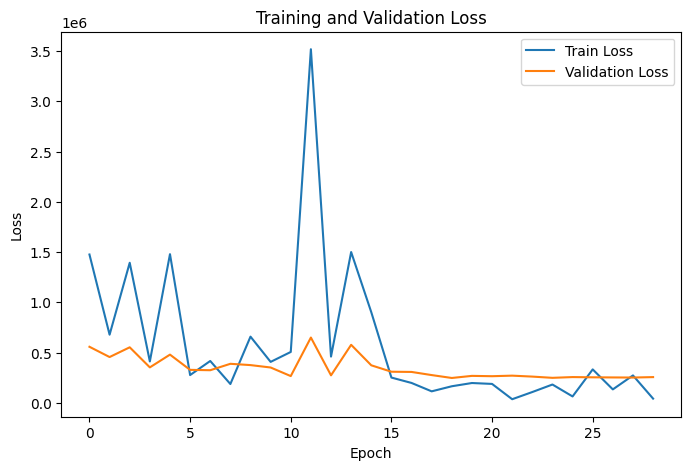

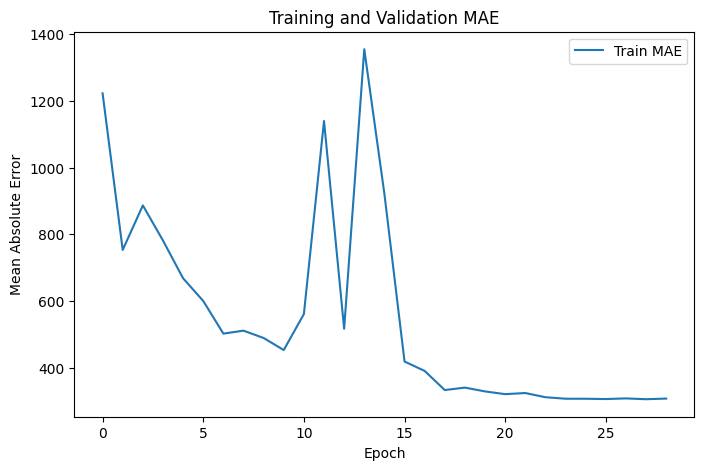

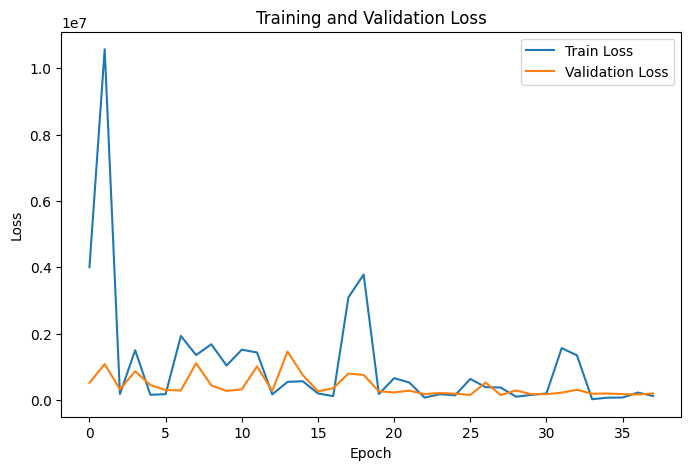

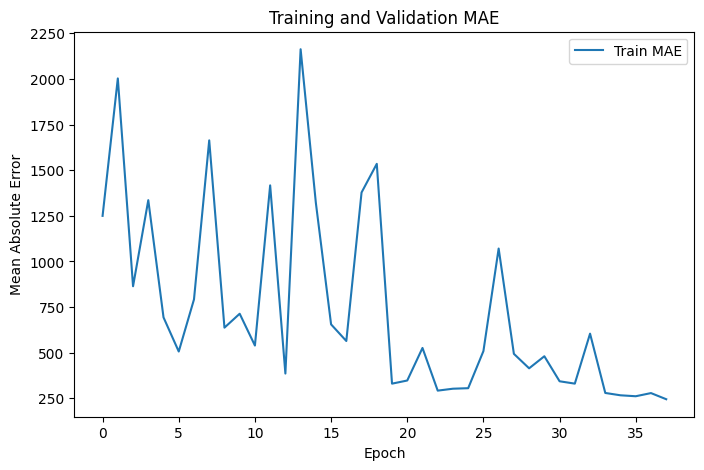

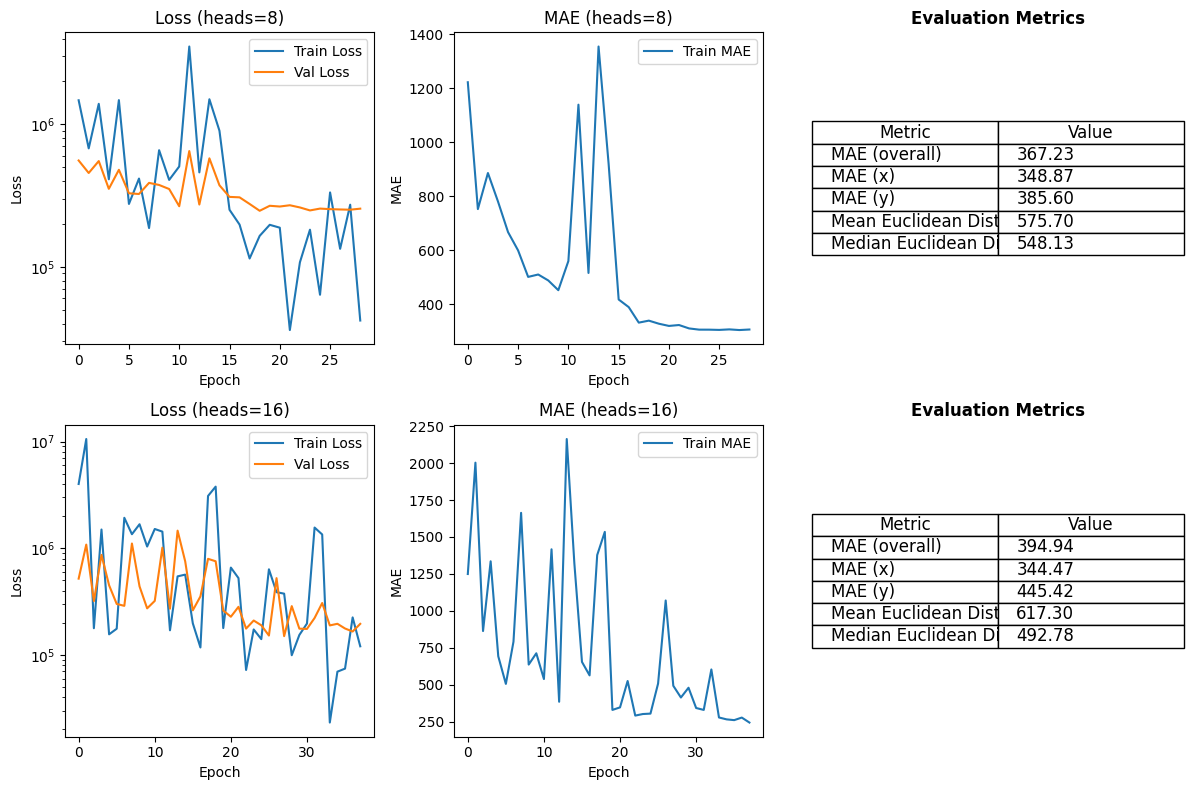

In [ ]:
""" 
Replace the learned attention mechanism with an attention mechanism based on the Cosine similarity between
node vectors.
"""

NUM_HEADS_LIST = [8, 16]
histories = []
metrics_list = []

for num_heads in NUM_HEADS_LIST:
    # Define hyper-parameters
    HIDDEN_UNITS = 100
    NUM_HEADS = num_heads
    NUM_LAYERS = 3
    OUTPUT_DIM = 2

    NUM_EPOCHS = 100
    LEARNING_RATE = 1e-4

    # Build mathematical model
    gat_model = GraphAttentionNetwork(
        HIDDEN_UNITS, NUM_HEADS, NUM_LAYERS, OUTPUT_DIM
    )

    early_stopping = keras.callbacks.EarlyStopping(
        monitor="val_loss", min_delta=1e-5, patience=10, verbose=1, restore_best_weights=True, start_from_epoch=0
    )

    reduce_lr = keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss", factor=0.1, patience=5, verbose=1, min_delta=1e-4, min_lr=1e-6
    )

    loss_fn = keras.losses.MeanSquaredError()
    optimizer = keras.optimizers.Adam(learning_rate=LEARNING_RATE)
    metrics = [
        keras.metrics.MeanAbsoluteError(),
        keras.metrics.MeanSquaredError(),
        keras.metrics.RootMeanSquaredError(name="rmse"),
        keras.metrics.R2Score(),
    ]

    gat_model.compile(optimizer=optimizer, loss=loss_fn, metrics=metrics)

    history = gat_model.fit(
        train_dataset,
        validation_data=val_dataset,
        epochs=NUM_EPOCHS,
        verbose=2,
        callbacks=[reduce_lr, early_stopping],
    )

    _, test_accuracy = gat_model.evaluate(x=test_dataset, verbose=1)
    print(f"Test Mean Absolute Error: {test_accuracy}")

    all_predictions = []
    all_ground_truth = []
    sample_count = 0

    print("Evaluating model on entire test dataset")

    for features, edges, targets in test_dataset:
        predictions = gat_model((features, edges), training=False)
        
        # Convert to numpy for easier handling
        pred_np = predictions.numpy()
        targets_np = targets.numpy()
        
        # Store predictions
        all_predictions.append(pred_np)
        all_ground_truth.append(targets_np)
        
        sample_count += len(pred_np)

    print(f"Processed {len(all_predictions)} scenes with {sample_count} total nodes")

    # Concatenate all predictions and ground truth values
    all_pred_concat = np.concatenate(all_predictions)
    all_gt_concat = np.concatenate(all_ground_truth)

    # Calculate MAE for x and y coordinates separately
    mae_x = np.mean(np.abs(all_pred_concat[:, 0] - all_gt_concat[:, 0]))
    mae_y = np.mean(np.abs(all_pred_concat[:, 1] - all_gt_concat[:, 1]))

    # Calculate overall MAE
    mae = np.mean(np.abs(all_pred_concat - all_gt_concat))

    # Calculate Euclidean distance for each prediction
    euclidean_distances = np.sqrt(np.sum((all_pred_concat - all_gt_concat)**2, axis=1))
    mean_euclidean = np.mean(euclidean_distances)
    median_euclidean = np.median(euclidean_distances)

    print("\n===== Evaluation Metrics =====")
    print(f"Mean Absolute Error (overall): {mae:.2f}")
    print(f"Mean Absolute Error (x-coordinate): {mae_x:.2f}")
    print(f"Mean Absolute Error (y-coordinate): {mae_y:.2f}")
    print(f"Mean Euclidean Distance: {mean_euclidean:.2f} units")
    print(f"Median Euclidean Distance: {median_euclidean:.2f} units")

    histories.append(history)
    metrics_list.append({
        "num_heads": num_heads,
        "mae": mae,
        "mae_x": mae_x,
        "mae_y": mae_y,
        "mean_euclidean": mean_euclidean,
        "median_euclidean": median_euclidean
    })


    plt.figure(figsize=(8, 5))
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.savefig(f"plotsTask3/loss_plot_heads{num_heads}_task3.png")
    #plt.show()
    

    plt.figure(figsize=(8, 5))
    plt.plot(history.history['mean_absolute_error'], label='Train MAE')
    if 'val_mean_absolute_error' in history.history:
        plt.plot(history.history['val_mean_absolute_error'], label='Validation MAE')
    plt.xlabel('Epoch')
    plt.ylabel('Mean Absolute Error')
    plt.title('Training and Validation MAE')
    plt.legend()
    plt.savefig(f"plotsTask3/MAE_plot_heads{num_heads}_task3.png")
    #plt.show()


fig, axes = plt.subplots(2, 3, figsize=(12, 8))

for idx, (history, metrics) in enumerate(zip(histories, metrics_list)):
    row = idx

    # --- Loss plot ---
    ax_loss = axes[row, 0]
    ax_loss.plot(history.history['loss'], label='Train Loss')
    ax_loss.plot(history.history['val_loss'], label='Val Loss')
    ax_loss.set_title(f'Loss (heads={metrics["num_heads"]})')
    ax_loss.set_xlabel('Epoch')
    ax_loss.set_ylabel('Loss')
    ax_loss.legend()
    ax_loss.set_yscale("log")

    # --- MAE plot ---
    ax_mae = axes[row, 1]
    ax_mae.plot(history.history['mean_absolute_error'], label='Train MAE')
    if 'val_mean_absolute_error' in history.history:
        ax_mae.plot(history.history['val_mean_absolute_error'], label='Val MAE')
    ax_mae.set_title(f'MAE (heads={metrics["num_heads"]})')
    ax_mae.set_xlabel('Epoch')
    ax_mae.set_ylabel('MAE')
    ax_mae.legend()

    # --- Metrics table ---
    ax_table = axes[row, 2]
    ax_table.axis('off')
    cell_text = [
        ["MAE (overall)", f"{metrics['mae']:.2f}"],
        ["MAE (x)", f"{metrics['mae_x']:.2f}"],
        ["MAE (y)", f"{metrics['mae_y']:.2f}"],
        ["Mean Euclidean Distance", f"{metrics['mean_euclidean']:.2f}"],
        ["Median Euclidean Distance", f"{metrics['median_euclidean']:.2f}"]
    ]
    table = ax_table.table(
        cellText=cell_text,
        colLabels=["Metric", "Value"],
        loc='center',
        cellLoc='left'
    )
    table.auto_set_font_size(False)
    table.set_fontsize(12)
    table.scale(1.2, 1.2)
    ax_table.set_title("Evaluation Metrics", fontweight="bold")

plt.tight_layout()
plt.savefig("plotsTask3/all_results_grid_task3.png")
plt.show()